In [127]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from itertools import combinations

# Data Processing

In [128]:
data = pd.read_csv('/workspaces/wiggle-face/data/panda_each_video/all_panda_features_updated.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285001 entries, 0 to 1285000
Data columns (total 34 columns):
 #   Column                                                Non-Null Count    Dtype  
---  ------                                                --------------    -----  
 0   infant_id                                             1285001 non-null  int64  
 1   date                                                  448436 non-null   float64
 2   cam                                                   448436 non-null   float64
 3   frame_id                                              1285001 non-null  int64  
 4   right_brow_mean_y                                     1285001 non-null  float64
 5   left_brow_mean_y                                      1285001 non-null  float64
 6   right_eye_distance                                    1285001 non-null  float64
 7   left_eye_distance                                     1285001 non-null  float64
 8   lips_distance                   

In [129]:
def remove_outliers(column):
    mean = column.mean()
    std = column.std()
    return column[(column >= mean - 3 * std) & (column <= mean + 3 * std)]

# Define your conditions
conditions = (
    (data['right_brow_mean_y'] >= 0.6) & (data['left_brow_mean_y'] >= 0.6) 
)
eye_width_condition = abs(data['right_eye_width'] - data['left_eye_width']) <= 0.1
eyebrow_width_condition = abs(data['right_eyebrow_width'] - data['left_eyebrow_width']) <= 0.2

# Apply the conditions
data = data[eye_width_condition & eyebrow_width_condition & conditions]

# Apply the remove_outliers function to all columns except 'infant_id'
columns_to_apply = data.columns.difference(['infant_id', 'frame_id', 'date', 'cam', 'age'])
data[columns_to_apply] = data[columns_to_apply].apply(remove_outliers)

# Reset the index and display info
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376517 entries, 0 to 376516
Data columns (total 34 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   infant_id                                             376517 non-null  int64  
 1   date                                                  105860 non-null  float64
 2   cam                                                   105860 non-null  float64
 3   frame_id                                              376517 non-null  int64  
 4   right_brow_mean_y                                     364227 non-null  float64
 5   left_brow_mean_y                                      364111 non-null  float64
 6   right_eye_distance                                    370698 non-null  float64
 7   left_eye_distance                                     371537 non-null  float64
 8   lips_distance                               

In [130]:
features = data.drop(columns=['infant_id', 'frame_id','date', 'cam', 'age'])
features

,right_brow_mean_y,left_brow_mean_y,right_eye_distance,left_eye_distance,lips_distance,left_eye_width,right_eye_width,left_eyebrow_width,right_eyebrow_width,lip_width,...,curvature_upper_left_brow,curvature_lower_left_brow,curvature_upper_left_eyelid,curvature_lower_left_eyelid,curvature_upper_right_eyelid,curvature_lower_right_eyelid,curvature_upper_outer_lip,curvature_lower_outer_lip,curvature_upper_inner_lip,curvature_lower_inner_lip
0,0.901760,0.843465,0.175058,0.185739,0.012644,0.506678,0.430091,0.752716,0.589096,0.670905,...,1.188671,0.636778,2.426133,1.263844,3.026428,1.562662,1.651708,1.932361,0.709494,0.245691
1,0.904089,0.851144,0.171311,0.181891,0.012543,0.508100,0.432293,0.745538,0.589904,0.664504,...,1.144263,0.631421,2.348470,1.275923,2.876486,1.577599,1.705647,1.991199,0.798197,0.028191
2,0.904192,0.868161,0.168297,0.178532,0.010381,0.498225,0.436430,0.754410,0.603837,0.679178,...,1.144648,0.562679,2.462608,1.345827,2.864451,1.588496,1.589688,1.925304,0.691536,0.021022
3,0.905433,0.889612,0.169986,0.175811,0.014533,0.490042,0.435499,0.741015,0.612841,0.658556,...,1.143823,0.677388,2.440670,1.193029,2.818799,1.686506,1.631812,2.473867,0.681219,0.028492
4,0.906771,0.898333,0.166822,0.172554,0.014203,0.486693,0.439863,0.728618,0.630383,0.670369,...,1.136115,0.663472,2.459143,1.375841,2.856202,1.467293,1.646472,1.827424,0.573086,0.120349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376512,0.848193,0.913853,0.100685,0.102096,0.081462,0.429777,0.499511,0.659189,0.765695,0.834792,...,1.179181,0.527772,2.508937,0.973699,1.833898,0.587129,1.626692,2.017898,0.670633,0.111385
376513,0.855153,0.913840,0.100185,0.100880,0.071267,0.438075,0.501575,0.647658,0.774488,0.833815,...,1.260172,0.479811,2.324102,1.052985,1.810921,0.828961,1.655888,2.142543,0.742374,0.037999
376514,0.854011,0.913481,0.088770,0.095622,0.057389,0.431408,0.498334,0.622322,0.784381,0.803948,...,1.298232,0.561585,2.120950,1.064636,1.640011,0.651165,1.755654,2.401272,0.702675,0.058855
376515,0.817609,0.918534,0.036804,0.053795,0.007079,0.441644,0.524365,0.611447,0.760014,0.855597,...,1.124091,0.442024,1.068734,0.561111,NaN,0.527072,1.131441,2.202350,0.151430,0.000006


In [131]:
missing_indices = features[features.isna().any(axis=1)].index

# Drop these rows from both features and data
features.dropna(inplace=True)
features = features.reset_index(drop=True)
data.drop(index=missing_indices, inplace=True)
data = data.reset_index(drop=True)

features

,right_brow_mean_y,left_brow_mean_y,right_eye_distance,left_eye_distance,lips_distance,left_eye_width,right_eye_width,left_eyebrow_width,right_eyebrow_width,lip_width,...,curvature_upper_left_brow,curvature_lower_left_brow,curvature_upper_left_eyelid,curvature_lower_left_eyelid,curvature_upper_right_eyelid,curvature_lower_right_eyelid,curvature_upper_outer_lip,curvature_lower_outer_lip,curvature_upper_inner_lip,curvature_lower_inner_lip
0,0.901760,0.843465,0.175058,0.185739,0.012644,0.506678,0.430091,0.752716,0.589096,0.670905,...,1.188671,0.636778,2.426133,1.263844,3.026428,1.562662,1.651708,1.932361,0.709494,0.245691
1,0.904089,0.851144,0.171311,0.181891,0.012543,0.508100,0.432293,0.745538,0.589904,0.664504,...,1.144263,0.631421,2.348470,1.275923,2.876486,1.577599,1.705647,1.991199,0.798197,0.028191
2,0.904192,0.868161,0.168297,0.178532,0.010381,0.498225,0.436430,0.754410,0.603837,0.679178,...,1.144648,0.562679,2.462608,1.345827,2.864451,1.588496,1.589688,1.925304,0.691536,0.021022
3,0.905433,0.889612,0.169986,0.175811,0.014533,0.490042,0.435499,0.741015,0.612841,0.658556,...,1.143823,0.677388,2.440670,1.193029,2.818799,1.686506,1.631812,2.473867,0.681219,0.028492
4,0.906771,0.898333,0.166822,0.172554,0.014203,0.486693,0.439863,0.728618,0.630383,0.670369,...,1.136115,0.663472,2.459143,1.375841,2.856202,1.467293,1.646472,1.827424,0.573086,0.120349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327542,0.892634,0.915112,0.089981,0.099848,0.042610,0.439916,0.481018,0.639860,0.725511,0.821663,...,1.354051,0.562181,2.188411,0.971543,1.816524,1.068976,1.324724,2.468606,0.511619,0.143623
327543,0.867385,0.910657,0.090284,0.096727,0.038309,0.423761,0.487104,0.605050,0.742010,0.814588,...,1.470873,0.685606,2.330060,0.747522,1.721391,1.064619,1.486834,2.484279,0.525853,0.047274
327544,0.848193,0.913853,0.100685,0.102096,0.081462,0.429777,0.499511,0.659189,0.765695,0.834792,...,1.179181,0.527772,2.508937,0.973699,1.833898,0.587129,1.626692,2.017898,0.670633,0.111385
327545,0.855153,0.913840,0.100185,0.100880,0.071267,0.438075,0.501575,0.647658,0.774488,0.833815,...,1.260172,0.479811,2.324102,1.052985,1.810921,0.828961,1.655888,2.142543,0.742374,0.037999


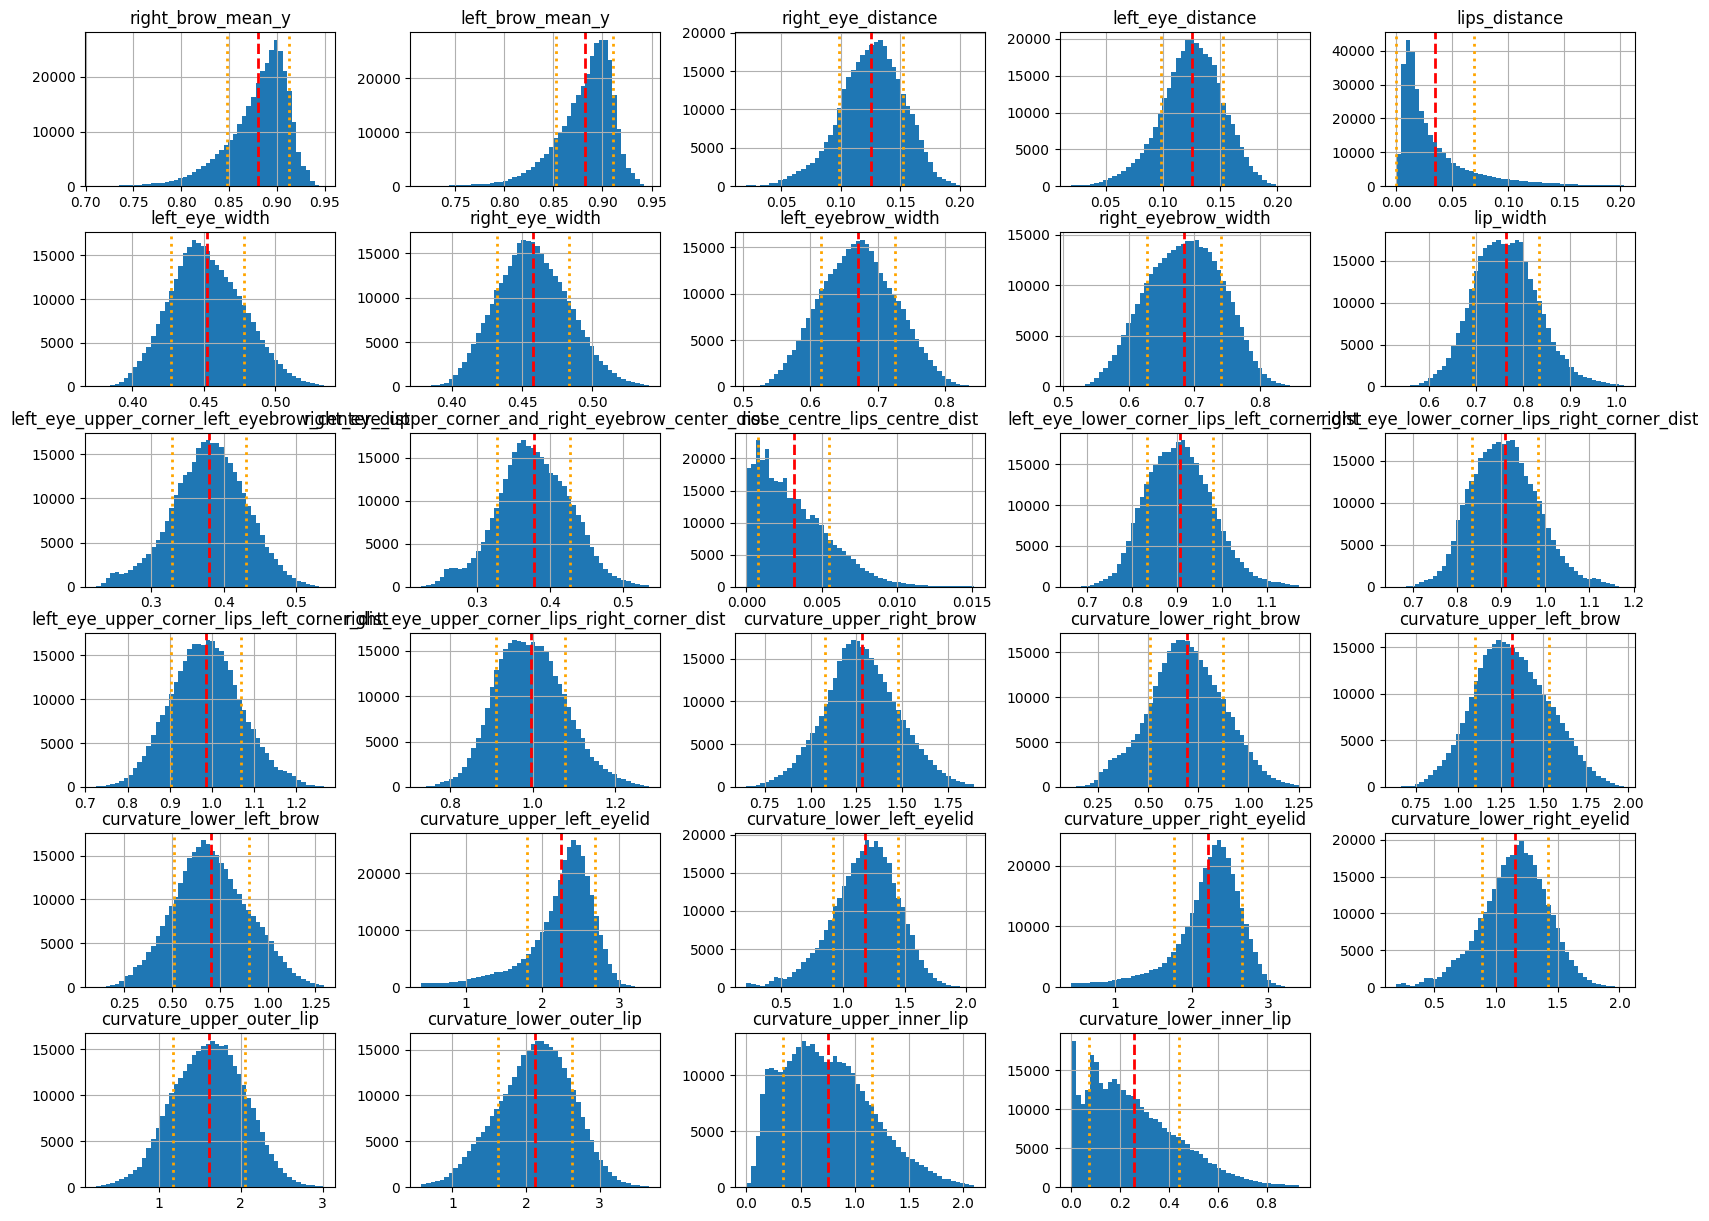

In [132]:
features.hist(bins=50, figsize=(20, 15))

# Calculate the mean and standard deviation for each feature and plot them
for feature in features.columns:
    mean = features[feature].mean()
    std = features[feature].std()
    
    # Get current subplot
    ax = plt.gcf().get_axes()[features.columns.get_loc(feature)]
    
    # Plot the mean line
    ax.axvline(mean, color='r', linestyle='dashed', linewidth=2)
    # Plot the standard deviation lines
    ax.axvline(mean - std, color='orange', linestyle='dotted', linewidth=2)
    ax.axvline(mean + std, color='orange', linestyle='dotted', linewidth=2)
    
plt.show()

In [133]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327547 entries, 0 to 327546
Data columns (total 29 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   right_brow_mean_y                                     327547 non-null  float64
 1   left_brow_mean_y                                      327547 non-null  float64
 2   right_eye_distance                                    327547 non-null  float64
 3   left_eye_distance                                     327547 non-null  float64
 4   lips_distance                                         327547 non-null  float64
 5   left_eye_width                                        327547 non-null  float64
 6   right_eye_width                                       327547 non-null  float64
 7   left_eyebrow_width                                    327547 non-null  float64
 8   right_eyebrow_width                         

In [134]:
mask_1 = (features['right_eye_distance'] >= 0.15) & (features['left_eye_distance'] >= 0.15)
mask_2 = features['right_eye_distance'].between(0.1, 0.15) & features['left_eye_distance'].between(0.1, 0.15)
mask_2_1 = features['right_eye_distance'].between(0.07, 0.1) & features['left_eye_distance'].between(0.07, 0.1)
mask_3 = (features['right_eye_distance'] <= 0.07) & (features['left_eye_distance'] <= 0.07)

mask_4 = ((features['left_brow_mean_y'] >= 0.9) & (features['right_brow_mean_y'] >= 0.9)) | ((features['left_eye_upper_corner_left_eyebrow_center_dist'] > 0.42) & (features['right_eye_upper_corner_and_right_eyebrow_center_dist'] > 0.42))
mask_4_1 = ((features['left_eye_upper_corner_left_eyebrow_center_dist'] < 0.33) & (features['right_eye_upper_corner_and_right_eyebrow_center_dist'] < 0.33))
mask_5 = ((features['curvature_lower_left_brow'] > 0.8) & (features['curvature_upper_left_brow'] > 1.35)) | ((features['curvature_lower_right_brow'] > 0.8) & (features['curvature_upper_right_brow'] > 1.35))
mask_5_1 = ((features['curvature_lower_left_brow'].between(0.6, 0.8)) & (features['curvature_upper_left_brow'].between(1,1.35))) & ((features['curvature_lower_right_brow'].between(0.6,0.8)) & (features['curvature_upper_right_brow'] .between(1,1.35)))
mask_6 = ((features['curvature_lower_left_brow'] < 0.5) & (features['curvature_upper_left_brow'] < 1)) | ((features['curvature_lower_right_brow'] < 0.5) & (features['curvature_upper_right_brow'] < 1))

mask_7 = features['lips_distance'] > 0.03
mask_8 = (features['curvature_upper_outer_lip'] > 1.75) & (features['curvature_lower_outer_lip'] > 2.3) & (features['lip_width'] < 0.8) & mask_7
mask_9 = features['lip_width'] >= 0.77
mask_10 = (features['curvature_lower_outer_lip'] > 2.17) 
mask_10_2 = ((features['left_eye_upper_corner_lips_left_corner_dist'] < 0.89) | (features['right_eye_upper_corner_lips_right_corner_dist'] < 0.89)) & ((features['left_eye_lower_corner_lips_left_corner_dist'] < 0.83) | (features['right_eye_lower_corner_lips_right_corner_dist'] < 0.83) )
mask_11 = (features['curvature_upper_outer_lip'] > 1.75) & (features['curvature_lower_outer_lip'] > 1.5)
mask_11_2 = (features['left_eye_upper_corner_lips_left_corner_dist'] > 1.07) | (features['right_eye_upper_corner_lips_right_corner_dist'] > 1.07) | (features['left_eye_lower_corner_lips_left_corner_dist'] > 0.97) | (features['right_eye_lower_corner_lips_right_corner_dist'] > 0.97)

mask_12 = ((features['curvature_lower_inner_lip'] <0.2) & (features['curvature_upper_outer_lip'] > 1.8)) | ((features['curvature_upper_inner_lip'] <0.5) & (features['curvature_lower_outer_lip'] > 2.3) )
mask_13 = mask_7 & (features['lip_width'] >= 0.8)

features['eyes_wide_open'] = mask_1
features['eyes_widened'] = mask_2
features['eyes_narrowed'] = mask_2_1
features['eyes_closed'] = mask_3

features['brows_raised'] = mask_4
features['brows_lowered'] = mask_4_1
features['brows_arched'] = mask_5
features['brows_normal'] = mask_5_1
features['brows_flat'] = mask_6

features['mouth_open'] = mask_7
features['mouth_gaping'] = mask_8
features['mouth_widened'] = mask_9
features['mouth_upturned'] = mask_10_2 #& mask_10
features['mouth_bow'] = mask_12

features['mouth_downturned'] = mask_11_2 #& mask_11
features['mouth_corners_down'] = mask_11_2

features['mouth_neutral'] = ~(mask_10_2) & ~(mask_11_2)
features['mouth_squared'] = mask_13

col_to_drop = [ 'right_eye_upper_corner_and_right_eyebrow_center_dist',
    'lips_distance', 'curvature_upper_outer_lip', 'curvature_lower_outer_lip', 'lip_width', 
    'left_eye_upper_corner_lips_left_corner_dist', 'right_eye_upper_corner_lips_right_corner_dist',
    'curvature_upper_inner_lip', 'curvature_lower_inner_lip', 'left_eye_lower_corner_lips_left_corner_dist', 
    'right_eye_lower_corner_lips_right_corner_dist', 'left_brow_mean_y', 'right_brow_mean_y',
    'left_eye_upper_corner_left_eyebrow_center_dist', 'curvature_lower_left_brow', 
    'curvature_lower_right_brow', 'curvature_upper_left_brow', 'curvature_upper_right_brow',
    'right_eye_distance', 'left_eye_distance', 'nose_centre_lips_centre_dist', 'left_eye_width', 'right_eye_width', 'left_eyebrow_width', 'right_eyebrow_width',
    'curvature_upper_left_eyelid', 'curvature_lower_left_eyelid', 'curvature_upper_right_eyelid', 'curvature_lower_right_eyelid'
]

features = features.drop(columns= col_to_drop).reset_index(drop=True)

In [135]:
count_true_false = features.apply(pd.value_counts).fillna(0).astype(int)
count_true_false

,eyes_wide_open,eyes_widened,eyes_narrowed,eyes_closed,brows_raised,brows_lowered,brows_arched,brows_normal,brows_flat,mouth_open,mouth_gaping,mouth_widened,mouth_upturned,mouth_bow,mouth_downturned,mouth_corners_down,mouth_neutral,mouth_squared
False,278490,131624,295289,320178,245162,288299,201260,303544,302237,204268,273962,179086,287916,264864,240046,240046,127132,297269
True,49057,195923,32258,7369,82385,39248,126287,24003,25310,123279,53585,148461,39631,62683,87501,87501,200415,30278


# K-Means

In [151]:
# apply PCA to the standardized data
pca = PCA(n_components=0.9)  # Retain 95% of variance
principal_components = pca.fit_transform(features)

# number of components selected
n_components = pca.n_components_
print(f'Number of components selected: {n_components}')

Number of components selected: 7


In [158]:
optimal_k = 7 # choose based on your elbow plot

# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=200)
data['cluster'] = kmeans.fit_predict(principal_components)

features['cluster'] = data['cluster']
grouped_data = data.drop(columns=['infant_id', 'frame_id', 'cam', 'date','age']).groupby('cluster').mean()
grouped_data_scaled = features.groupby('cluster').mean()
# analyze the clusters
print(grouped_data_scaled)

         eyes_wide_open  eyes_widened  eyes_narrowed  eyes_closed  \
cluster                                                             
0              0.324412      0.000000       0.272758     0.060634   
1              0.000000      1.000000       0.000000     0.000000   
2              0.000000      1.000000       0.000000     0.000000   
3              0.261488      0.515382       0.072362     0.017127   
4              0.277055      0.480093       0.079607     0.015303   
5              0.115610      0.636956       0.098853     0.021418   
6              0.030613      0.677361       0.131867     0.036442   

         brows_raised  brows_lowered  brows_arched  brows_normal  brows_flat  \
cluster                                                                        
0            0.262465       0.149793      0.287708      0.097370    0.096474   
1            0.153761       0.196541      0.403781      0.070314    0.052957   
2            0.281566       0.086013      0.427146      0.

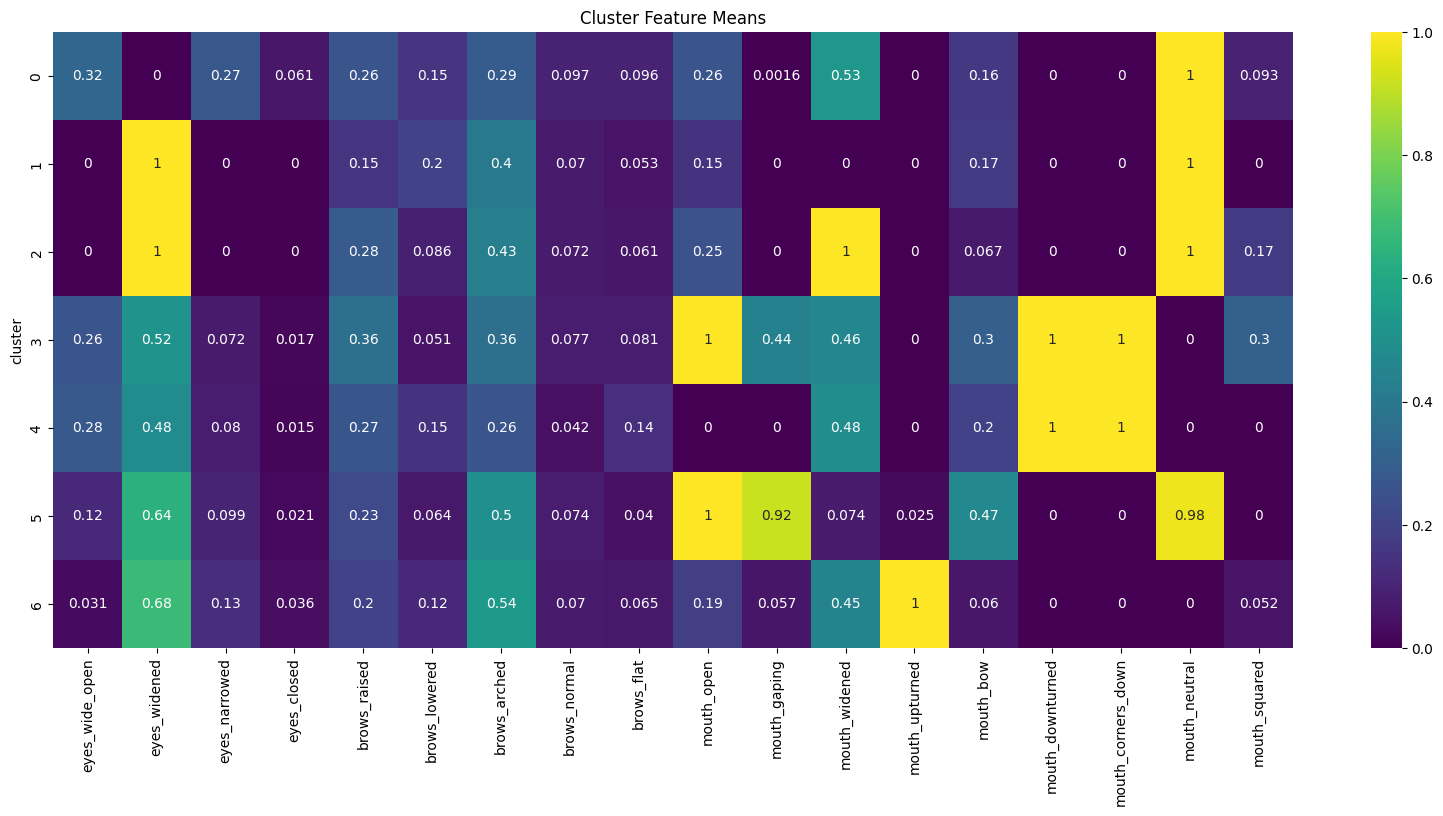

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap to visualize the average feature values for each cluster
plt.figure(figsize=(20, 8))
sns.heatmap(grouped_data_scaled, annot=True, cmap='viridis')
plt.title('Cluster Feature Means')
plt.show()

In [160]:
emotion_counts = data['cluster'].value_counts()
print(emotion_counts)

0    62473
2    54108
1    49720
3    43849
4    43652
6    38774
5    34971
Name: cluster, dtype: int64
